In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import scipy
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
from scipy import sparse
import hypernetx as hnx
from scipy.stats import qmc
from scipy import stats
import sklearn.metrics

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central
import core_utils

/home/cstansbu/miniconda3/envs/higher_order/lib/python3.12/site-packages/xgi/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
num_core_nodes = 4
num_periphery_nodes = 15
edge_probability_core = 0.95
edge_probability_periphery = 0.1
avg_edge_size = 3
core_periphery_probability = 0.1

CP = core_utils.generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

core_nodes, periphery_nodes, edges, incidence_matrix = CP

H = pd.DataFrame(incidence_matrix)
print(f"{H.shape=}")

H.shape=(19, 10)


# Effect of Core Size

In [3]:
total_nodes = 50
start = 5
step = 1
core_size = np.arange(start, total_nodes-start, step).astype(int)
edge_probability_core = 0.95
edge_probability_periphery = 0.1
avg_edge_size = 3
core_periphery_probability = 0.1

results = []

for cs in core_size:
    num_core_nodes = cs
    num_periphery_nodes = total_nodes - cs

    _, _, _, H = core_utils.generate_core_periphery_hypergraph(
        num_core_nodes, 
        num_periphery_nodes, 
        edge_probability_core, 
        edge_probability_periphery, 
        avg_edge_size, 
        core_periphery_probability,
    )
    
    score, _ = central.nonlinear_eigenvector_centrality(
        H, 
        function='linear', 
        maxiter=1000,
    )
    
    row = {
        'core_size' : cs,
    }
    
    for i in range(total_nodes):
        row[i] = score[i]
            
    results.append(row)    
    
    
results = pd.DataFrame(results)
print(f"{results.shape=}")
# results = pd.melt(results, id_vars='core_size', var_name='node')
results.head()

results.shape=(40, 51)


,core_size,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,5,0.095687,0.159247,0.038403,0.055901,0.152636,0.000000,0.015668,0.000000,0.012299,...,0.002015,0.029123,0.001166,0.020455,0.008440,0.008440,0.012308,0.002850,0.023277,0.011817
1,6,0.162494,0.079090,0.032900,0.166963,0.014383,0.109472,0.029370,0.013412,0.000000,...,0.004508,0.012152,0.000000,0.010464,0.000000,0.045200,0.000000,0.004957,0.000000,0.022847
2,7,0.115391,0.019648,0.142367,0.091587,0.039520,0.042982,0.080295,0.015098,0.010355,...,0.019443,0.000000,0.007313,0.000000,0.002698,0.000000,0.019336,0.005268,0.006254,0.014159
3,8,0.171467,0.088239,0.044480,0.074366,0.092794,0.088993,0.016547,0.020703,0.001178,...,0.000000,0.007643,0.014106,0.013791,0.024689,0.001918,0.003724,0.001734,0.048188,0.002570
4,9,0.055926,0.099798,0.014789,0.098766,0.058820,0.133852,0.037297,0.020438,0.034191,...,0.000000,0.020189,0.011347,0.011716,0.017208,0.003301,0.000000,0.015545,0.000816,0.003301


/home/cstansbu/miniconda3/envs/higher_order/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Text(0.5, 237.64444444444436, 'Node')

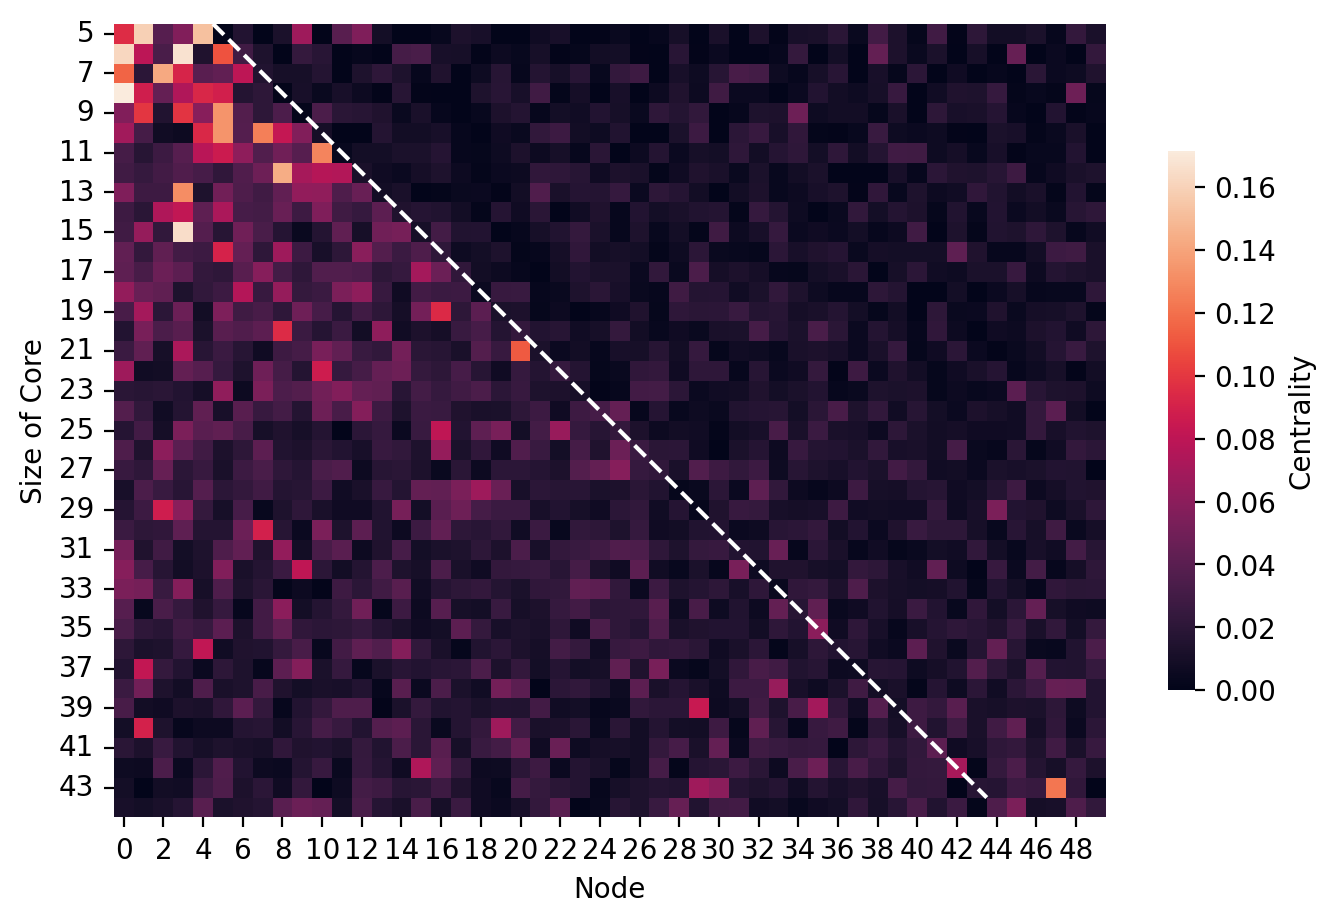

In [4]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 7

sns.heatmap(
    results.set_index('core_size'),
    square=True,
    cbar_kws={'shrink' : 0.5, 'label' : 'Centrality'}  
)

plt.plot(core_size, range(len(core_size)), color='w', linestyle='--')

plt.gca().tick_params(axis='y', rotation=0)
plt.ylabel("Size of Core")
plt.xlabel("Node")

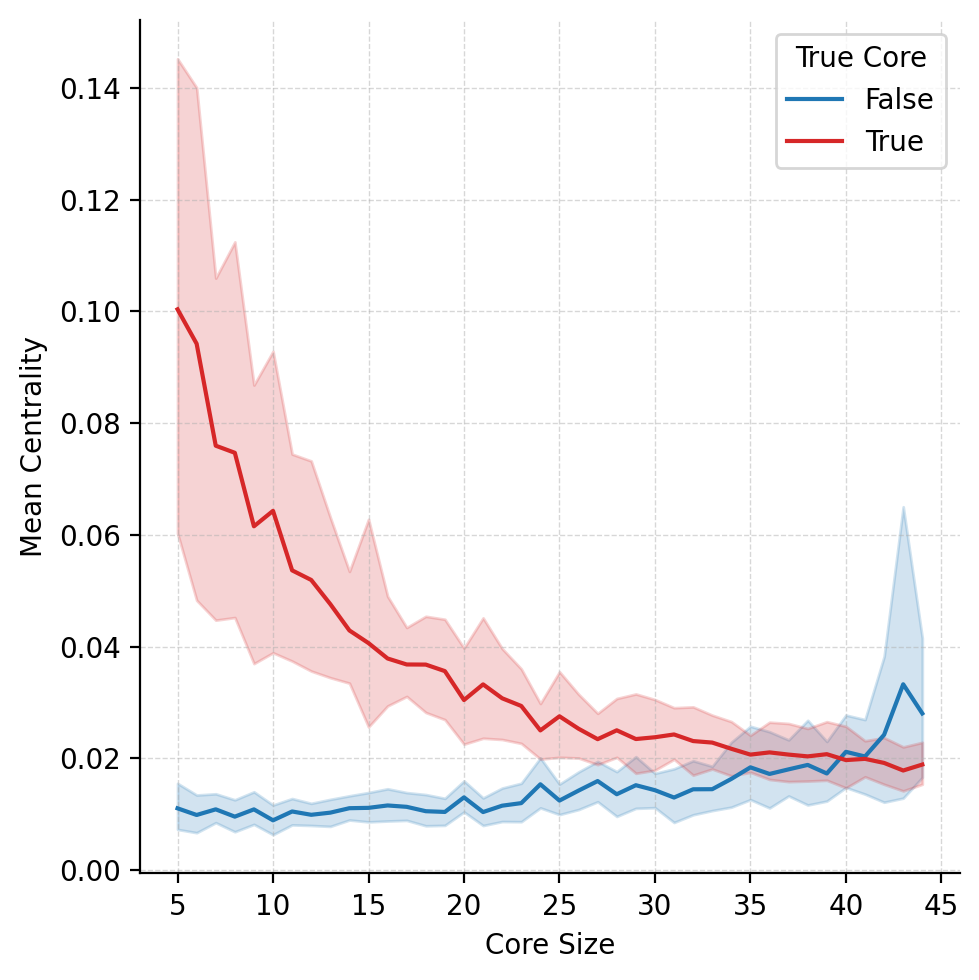

In [5]:
pdf = pd.melt(
    results, 
    id_vars='core_size',
    var_name='node',
    value_name='centrality',
)

pdf = pdf.sort_values(by=['core_size', 'node'])
pdf['core'] = pdf['node'] < (pdf['core_size'] )

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

# 2. Use a More Neutral and Professional Color Palette
sns.lineplot(
    data=pdf,
    x='core_size',
    y='centrality',
    hue='core',
    palette=["#1f77b4", "#d62728"],  # Classic blue and red from 'tab10' palette
    lw=1.5,  # Slightly thicker lines for better visibility
)

plt.xlabel("Core Size")
plt.ylabel("Mean Centrality")

# 4. Customize Legend for Readability
plt.legend(
    title="True Core",
)

# 5. Add Grid for Easier Value Estimation
plt.grid(True, linestyle="--", lw=0.5, alpha=0.5)  # Subtle grid

# 6. Remove Top and Right Spines for a Cleaner Look (Optional)
sns.despine()

# 7. Tight Layout to Prevent Overlapping Elements
plt.tight_layout()


# Effect of core edge probabilities

In [6]:
total_nodes = 50
num_core_nodes = int(0.25 * (total_nodes))
print(num_core_nodes)
num_periphery_nodes = total_nodes - num_core_nodes
avg_edge_size = 3
steps = 50

core_core_range = np.linspace(0, 1, steps)
edge_probability_periphery = 0.25
core_periphery_probability = 0.05

results = []


for edge_probability_core in core_core_range:

    core_nodes, _, _, H = core_utils.generate_core_periphery_hypergraph(
        num_core_nodes, 
        num_periphery_nodes, 
        edge_probability_core, 
        edge_probability_periphery, 
        avg_edge_size, 
        core_periphery_probability,
    )
    
    score, _ = central.nonlinear_eigenvector_centrality(
        H, 
        function='linear', 
        maxiter=1000,
    )
    
    row = {
        'core_px' : edge_probability_core,
    }
    
    for i in range(total_nodes):
        row[i] = score[i]
            
    results.append(row)    
    # break
    
results = pd.DataFrame(results)
print(f"{results.shape=}")
results.head()

12
results.shape=(50, 51)


,core_px,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.052870,0.027963,0.025435,0.001332,9.870972e-03,0.051947,0.000000,0.004083,0.028872,...,0.035325,0.008589,0.150149,0.037382,2.930961e-03,0.053624,0.002012,0.011825,0.002120,0.038497
1,0.020408,0.122494,0.012455,0.012979,0.000000,5.070951e-02,0.009006,0.056438,0.004698,0.028865,...,0.024035,0.027612,0.016235,0.002944,1.786571e-02,0.027618,0.000000,0.029535,0.055256,0.012114
2,0.040816,0.000364,0.017172,0.006723,0.124689,8.546621e-03,0.003325,0.017139,0.043326,0.020247,...,0.000007,0.062433,0.019919,0.046380,7.331990e-06,0.122217,0.003491,0.002454,0.000052,0.001214
3,0.061224,0.007842,0.151300,0.024780,0.025234,6.057476e-02,0.021269,0.007453,0.002585,0.006296,...,0.004338,0.004273,0.015293,0.024082,8.752116e-02,0.005281,0.012815,0.015003,0.000000,0.003447
4,0.081633,0.051699,0.021549,0.019189,0.065592,7.719914e-25,0.033952,0.002742,0.000000,0.003168,...,0.096535,0.029632,0.052495,0.004641,7.719914e-25,0.000426,0.009013,0.006526,0.004069,0.004588


Text(0.5, 138.44444444444431, 'Node')

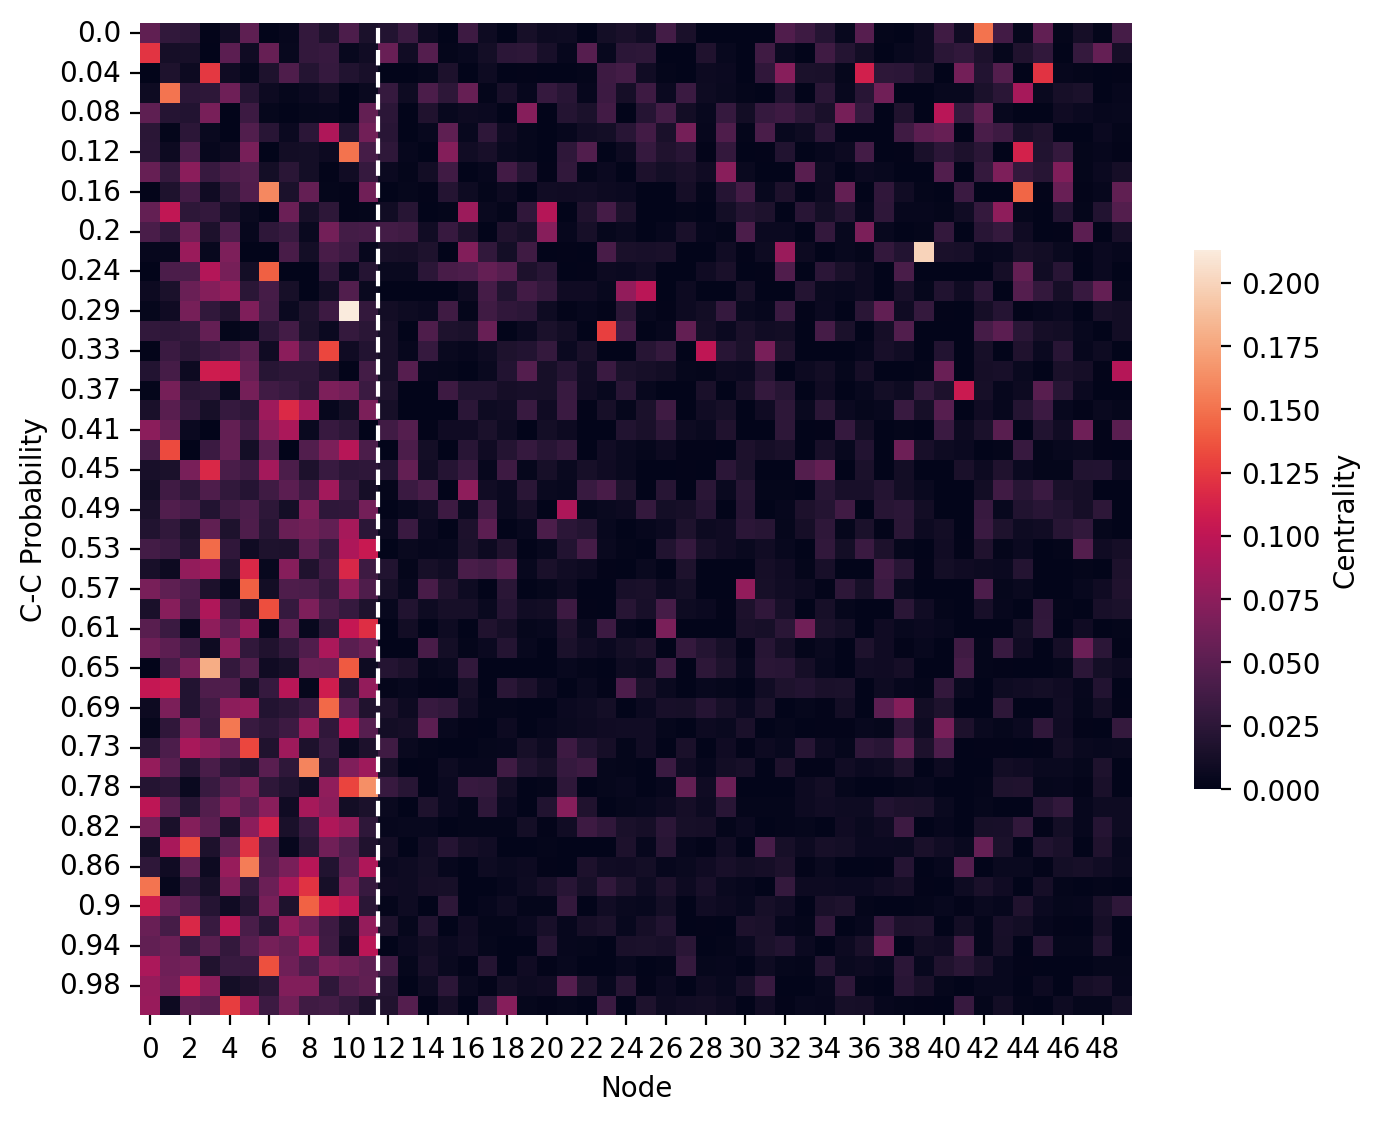

In [7]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 7

pdf = results.set_index('core_px')
pdf.index = pdf.index.round(2)

sns.heatmap(
    pdf,
    square=True,
    cbar_kws={'shrink' : 0.5, 'label' : 'Centrality'}  
)

plt.axvline(x=num_core_nodes, color='w', linestyle='--')


plt.ylabel("C-C Probability")
plt.xlabel("Node")

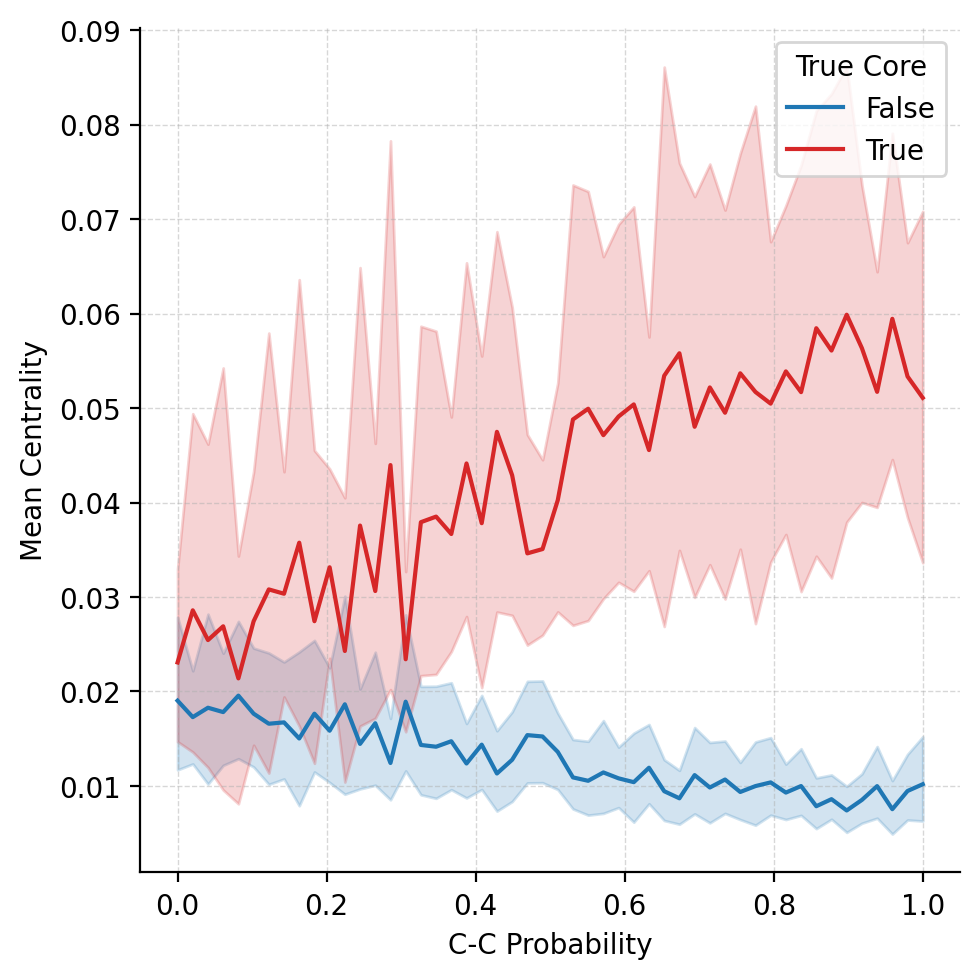

In [8]:
pdf = pd.melt(
    results, 
    id_vars='core_px',
    var_name='node',
    value_name='centrality',
)

pdf = pdf.sort_values(by=['core_px', 'node'])
pdf['core'] = pdf['node'] < num_core_nodes

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

# 2. Use a More Neutral and Professional Color Palette
sns.lineplot(
    data=pdf,
    x='core_px',
    y='centrality',
    hue='core',
    palette=["#1f77b4", "#d62728"],  # Classic blue and red from 'tab10' palette
    lw=1.5,  # Slightly thicker lines for better visibility
)

plt.xlabel("C-C Probability")
plt.ylabel("Mean Centrality")

# 4. Customize Legend for Readability
plt.legend(
    title="True Core",
)

# 5. Add Grid for Easier Value Estimation
plt.grid(True, linestyle="--", lw=0.5, alpha=0.5)  # Subtle grid

# 6. Remove Top and Right Spines for a Cleaner Look (Optional)
sns.despine()

# 7. Tight Layout to Prevent Overlapping Elements
plt.tight_layout()

# limits of detection

In [9]:
reload(core_utils)

parameters = {
    "num_core_nodes": [5, 65],
    "edge_probability_core": [0, 1],
    "edge_probability_periphery": [0, 1],
    "core_periphery_probability": [0, 1],
    "avg_edge_size" : [2, 6],
}

# Number of samples
num_samples = 1000
total_nodes = 100

# Generate the samples and get the DataFrame
params = core_utils.generate_params(
    parameters,
    num_samples,
)

print(f"{params.shape=}")
params['num_core_nodes'] = params['num_core_nodes'].astype(int)
params['num_periphery_nodes'] = total_nodes - params['num_core_nodes']
params['avg_edge_size'] = params['avg_edge_size'].astype(int)
params.head()

params.shape=(1000, 6)


,num_core_nodes,edge_probability_core,edge_probability_periphery,core_periphery_probability,avg_edge_size,key,num_periphery_nodes
0,24,0.439588,0.351915,0.091718,5,0,76
1,56,0.871512,0.614896,0.608813,2,1,44
2,31,0.283786,0.113395,0.042013,3,2,69
3,15,0.932689,0.635451,0.047578,5,3,85
4,34,0.953307,0.962745,0.132973,4,4,66


In [10]:
def compute_metrics(y_true, y_pred):
    """
    Computes sensitivity, precision, and AUC given binary y_true and y_pred.

    Args:
      y_true (array-like): True binary labels (0 or 1).
      y_pred (array-like): Predicted binary labels (0 or 1).

    Returns:
      tuple: A tuple containing sensitivity, precision, and AUC.
    """

    # Compute the confusion matrix
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true, y_pred).ravel()

    # Calculate sensitivity (recall or true positive rate)
    sensitivity = tp / (tp + fn)

    # Calculate precision
    precision = tp / (tp + fp)
    
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Calculate AUC (Area Under the Receiver Operating Characteristic Curve)
    auc = sklearn.metrics.roc_auc_score(y_true, y_pred)

    return sensitivity, precision, auc, accuracy


threshold = 0.5
results = []

for i, row in params.iterrows():
    num_core_nodes = int(row['num_core_nodes'])
    num_periphery_nodes = int(row['num_periphery_nodes'])
    edge_probability_core = row['edge_probability_core']
    edge_probability_periphery = row['edge_probability_periphery']
    core_periphery_probability = row['core_periphery_probability']
    avg_edge_size = row['avg_edge_size']
    
    core_nodes, _, _, H = core_utils.generate_core_periphery_hypergraph(
        num_core_nodes, 
        num_periphery_nodes, 
        edge_probability_core, 
        edge_probability_periphery, 
        avg_edge_size, 
        core_periphery_probability,
    )
    
    score, _ = central.nonlinear_eigenvector_centrality(
        H, 
        function='linear', 
        maxiter=1000,
    )
    c_score = score[:num_core_nodes]
    p_score = score[num_core_nodes:]
    
    y_true = np.concatenate(
        (np.ones(num_core_nodes), np.zeros(num_periphery_nodes))
    )

    q = np.quantile(score, threshold)
    y_pred = np.where(score > q, 1, 0)
    
    sensitivity, precision, auc, accuracy = compute_metrics(y_true, y_pred)
    
    t_statistic, p_value = stats.ttest_ind(
        c_score, 
        p_score, 
        alternative='greater',
    )
    
    row = {
        'core_percent' : num_core_nodes / total_nodes,
        'cc_px' : edge_probability_core,
        'pp_px' : edge_probability_periphery,
        'cp_px' : core_periphery_probability,
        'mean_order' : avg_edge_size,
        'mean_c_score' : np.mean(c_score),
        'mean_p_score' : np.mean(p_score),
        'p_value' : p_value,
        'significant' : p_value < 0.000001,
        'threshold' : q,
        'sensitivity' : sensitivity,
        'precision' : precision,
        'auc' : auc,
        'accuracy' : accuracy,
    }
    results.append(row)
    
    if i % 100 == 0:
        print(f"sample {i} of {len(params)}...")

results = pd.DataFrame(results)
print(f"{results.shape=}")
results.head()

sample 0 of 1000...
sample 100 of 1000...
sample 200 of 1000...
sample 300 of 1000...
sample 400 of 1000...
sample 500 of 1000...
sample 600 of 1000...
sample 700 of 1000...
sample 800 of 1000...
sample 900 of 1000...
results.shape=(1000, 14)


,core_percent,cc_px,pp_px,cp_px,mean_order,mean_c_score,mean_p_score,p_value,significant,threshold,sensitivity,precision,auc,accuracy
0,0.24,0.439588,0.351915,0.091718,5.0,0.014840,0.008472,1.167411e-10,True,0.009172,0.833333,0.40,0.719298,0.66
1,0.56,0.871512,0.614896,0.608813,2.0,0.009004,0.011267,9.994023e-01,False,0.009334,0.375000,0.42,0.357955,0.36
2,0.31,0.283786,0.113395,0.042013,3.0,0.015573,0.007496,8.967054e-05,False,0.006422,0.741935,0.46,0.675316,0.65
3,0.15,0.932689,0.635451,0.047578,5.0,0.025101,0.007335,1.616919e-26,True,0.007646,1.000000,0.30,0.794118,0.65
4,0.34,0.953307,0.962745,0.132973,4.0,0.013512,0.008191,3.196273e-11,True,0.008979,0.794118,0.54,0.722816,0.70


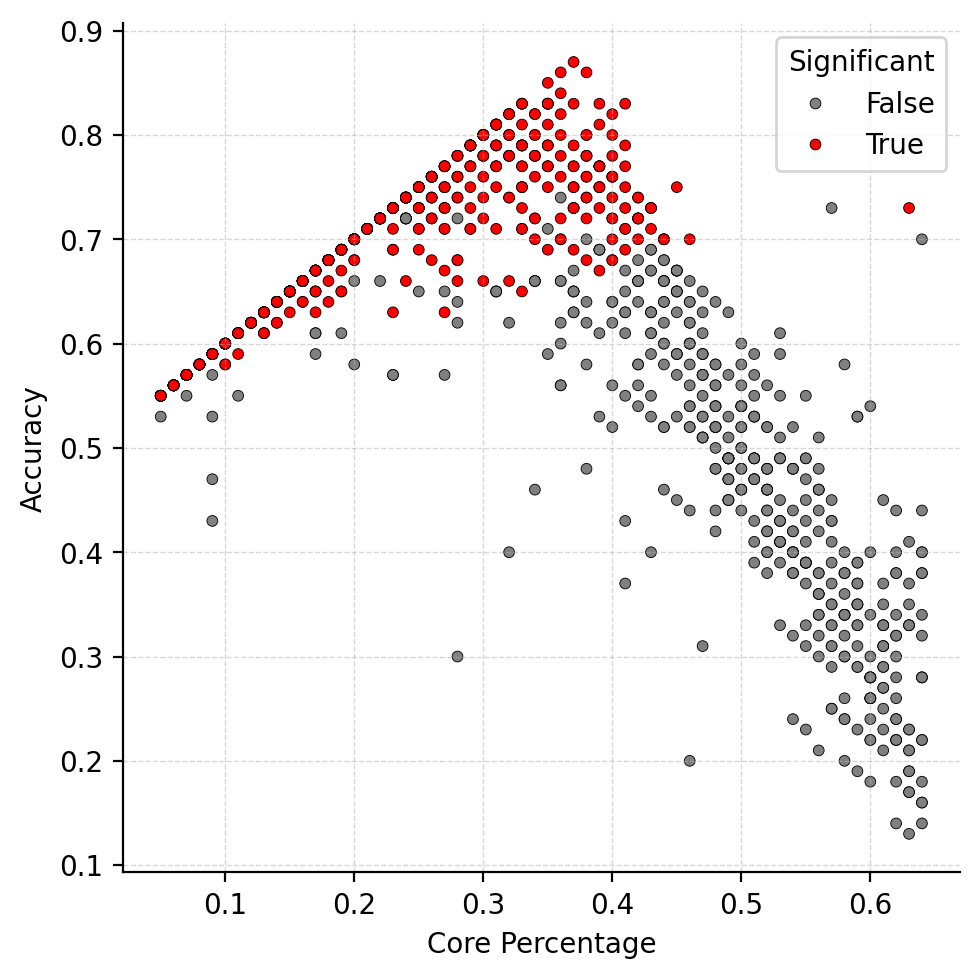

In [14]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    data=results,
    x='core_percent',
    y='accuracy',
    hue='significant',
    ec='k',  
    s=15,
    palette=['grey', 'r'],
)

# Add labels and title
plt.xlabel('Core Percentage')
plt.ylabel('Accuracy')

# Add legend
plt.legend(title='Significant')

plt.grid(True, linestyle="--", lw=0.5, alpha=0.5) 
sns.despine()
plt.tight_layout()  

In [15]:
results.head()

,core_percent,cc_px,pp_px,cp_px,mean_order,mean_c_score,mean_p_score,p_value,significant,threshold,sensitivity,precision,auc,accuracy
0,0.24,0.439588,0.351915,0.091718,5.0,0.014840,0.008472,1.167411e-10,True,0.009172,0.833333,0.40,0.719298,0.66
1,0.56,0.871512,0.614896,0.608813,2.0,0.009004,0.011267,9.994023e-01,False,0.009334,0.375000,0.42,0.357955,0.36
2,0.31,0.283786,0.113395,0.042013,3.0,0.015573,0.007496,8.967054e-05,False,0.006422,0.741935,0.46,0.675316,0.65
3,0.15,0.932689,0.635451,0.047578,5.0,0.025101,0.007335,1.616919e-26,True,0.007646,1.000000,0.30,0.794118,0.65
4,0.34,0.953307,0.962745,0.132973,4.0,0.013512,0.008191,3.196273e-11,True,0.008979,0.794118,0.54,0.722816,0.70


In [38]:
results.columns.to_list()

['core_percent',
 'cc_px',
 'pp_px',
 'cp_px',
 'mean_order',
 'mean_c_score',
 'mean_p_score',
 'p_value',
 'significant',
 'threshold',
 'sensitivity',
 'precision',
 'auc',
 'accuracy']

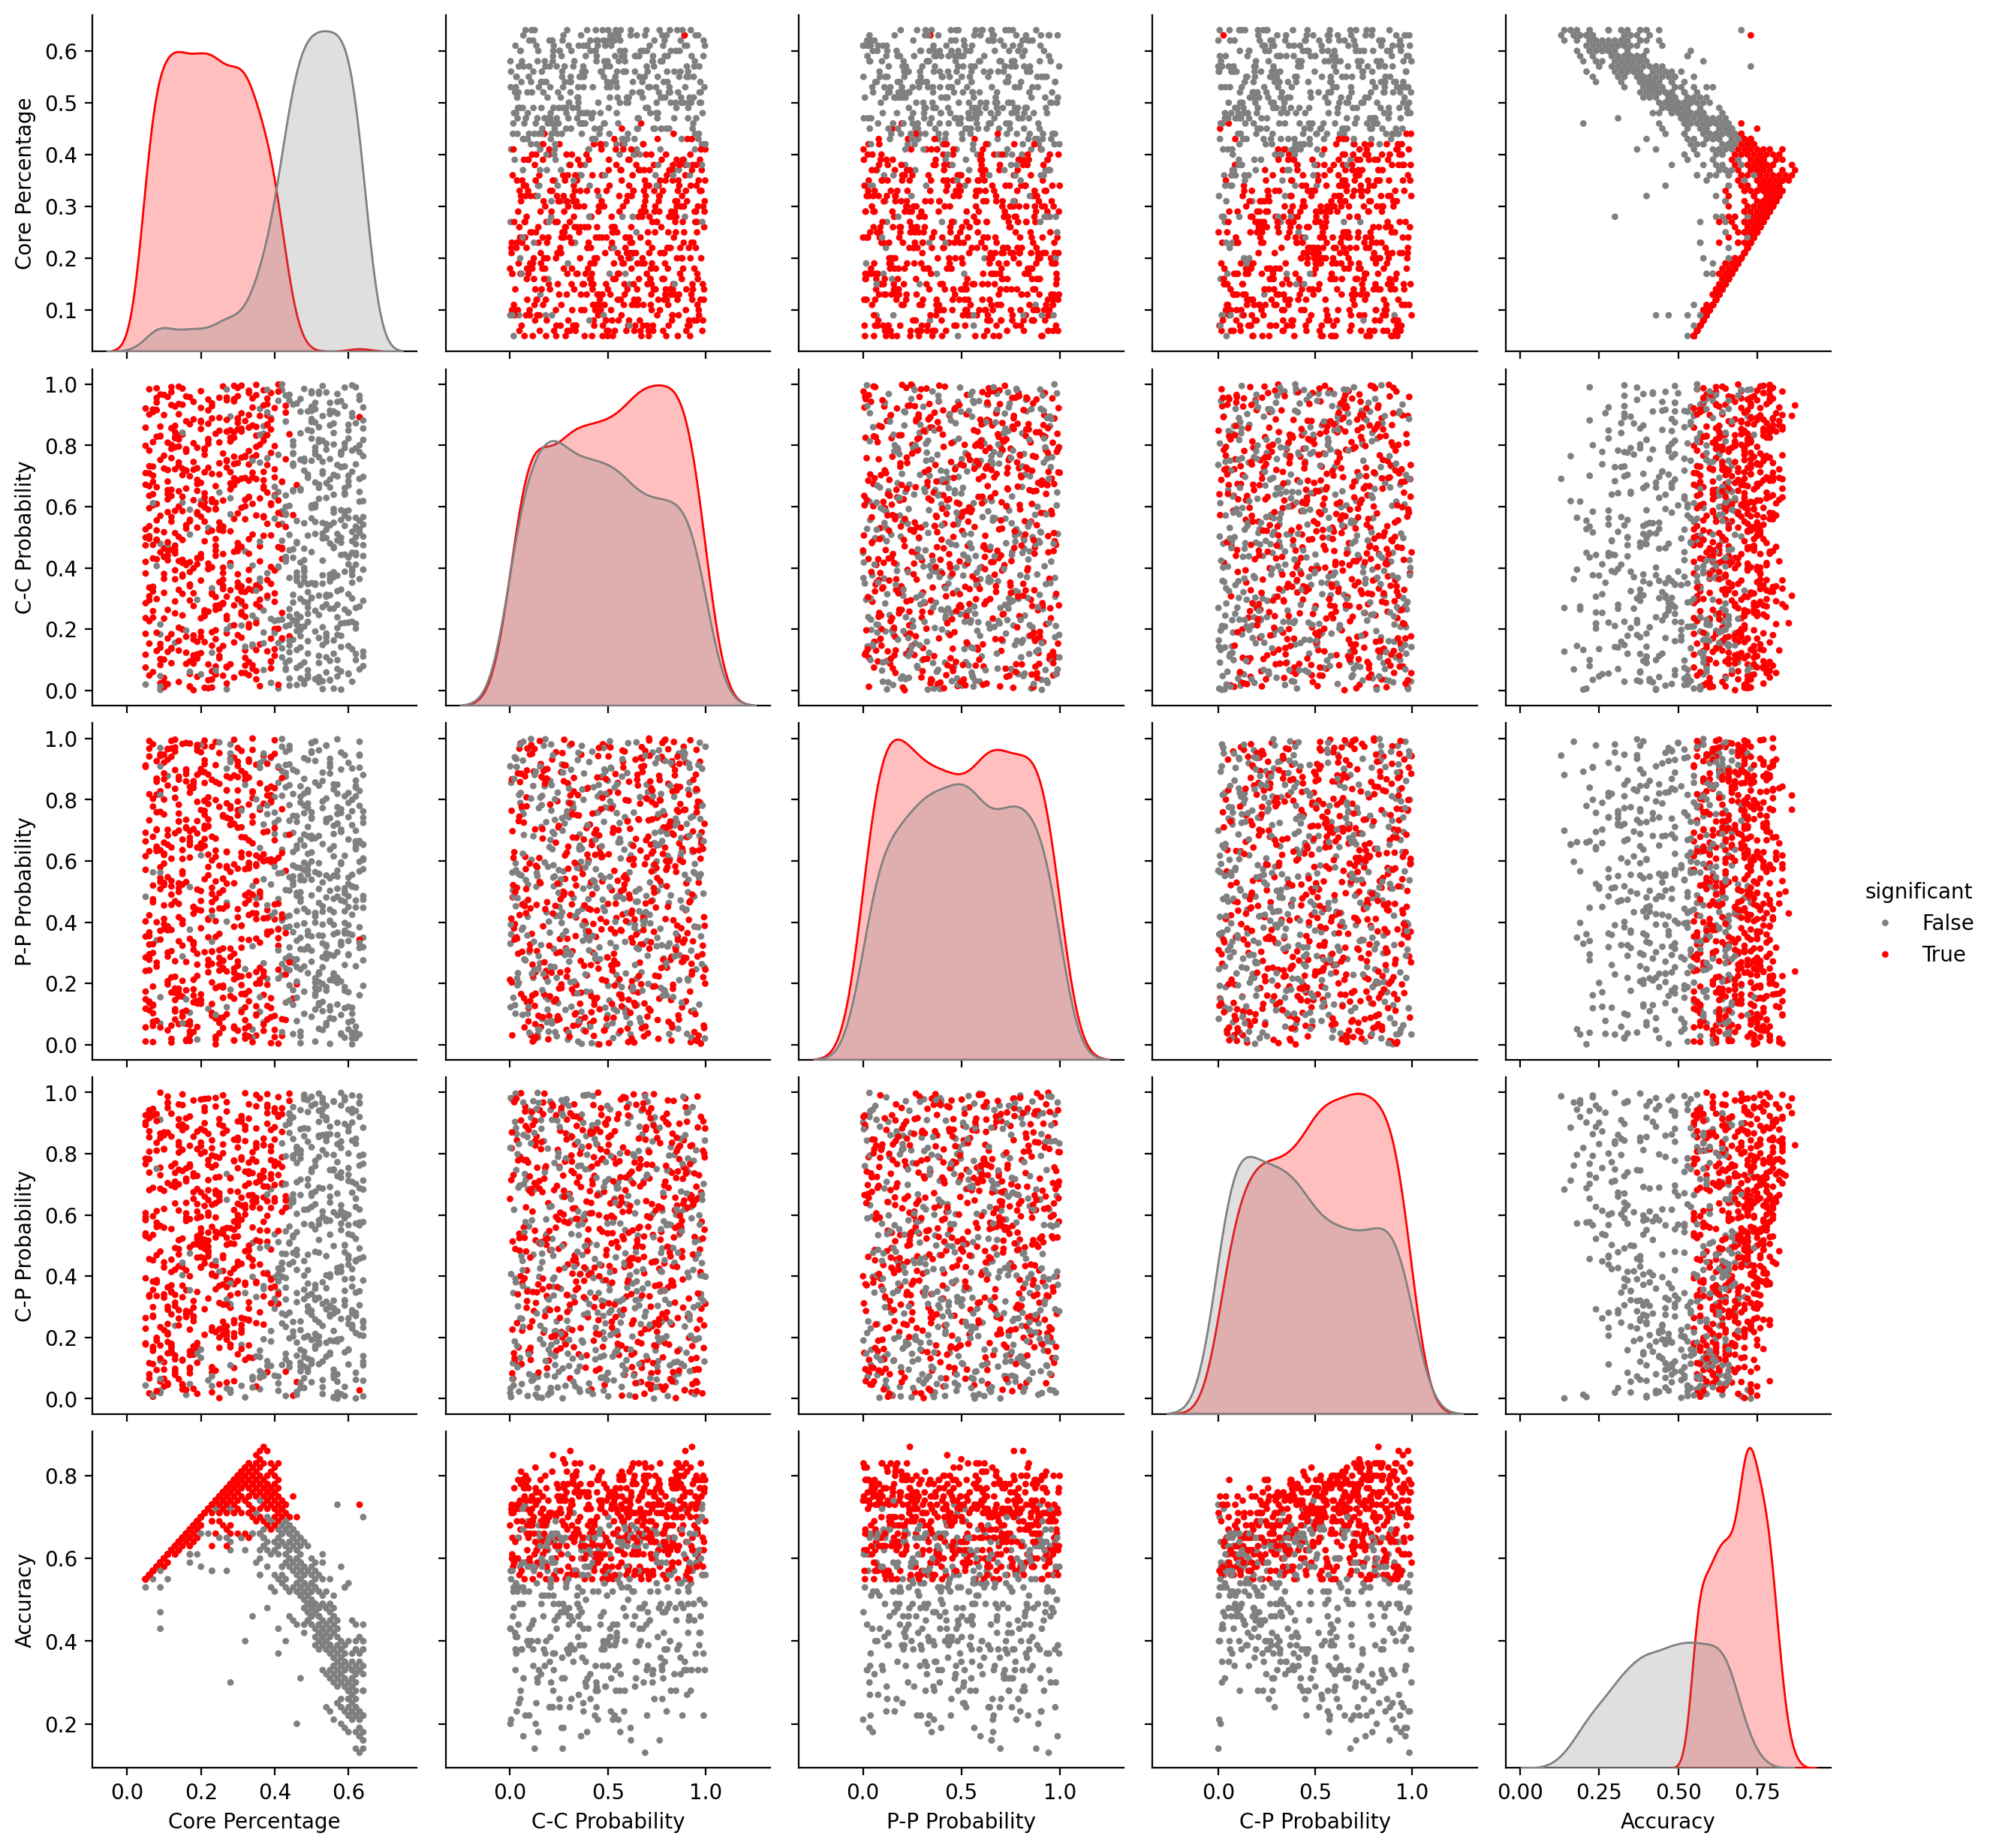

In [62]:
columns = [
    'core_percent',
    'cc_px',
    'pp_px',
    'cp_px',
    'accuracy',
    'significant',
]

g = sns.pairplot(
    results[columns],
    hue="significant",
    palette=['grey', 'r'],
    plot_kws={'ec': 'none', 's': 10}
)

# Add custom axis labels (replace with your desired labels)
axis_labels = {
    'core_percent': 'Core Percentage',
    'cc_px': 'C-C Probability',
    'pp_px': 'P-P Probability',
    'cp_px': 'C-P Probability',
    'accuracy': 'Accuracy'
}

# Remove 'significant' from columns for numerical plotting
numerical_columns = [col for col in columns if col != 'significant']

# Set the axis labels
for i, ax in enumerate(g.axes.flat):
    ax.set_xlabel(axis_labels[numerical_columns[i % len(numerical_columns)]])
    ax.set_ylabel(axis_labels[numerical_columns[i // len(numerical_columns)]])

,mean_order,variable,value
0,5.0,sensitivity,0.833333
1,2.0,sensitivity,0.375000
2,3.0,sensitivity,0.741935
3,5.0,sensitivity,1.000000
4,4.0,sensitivity,0.794118


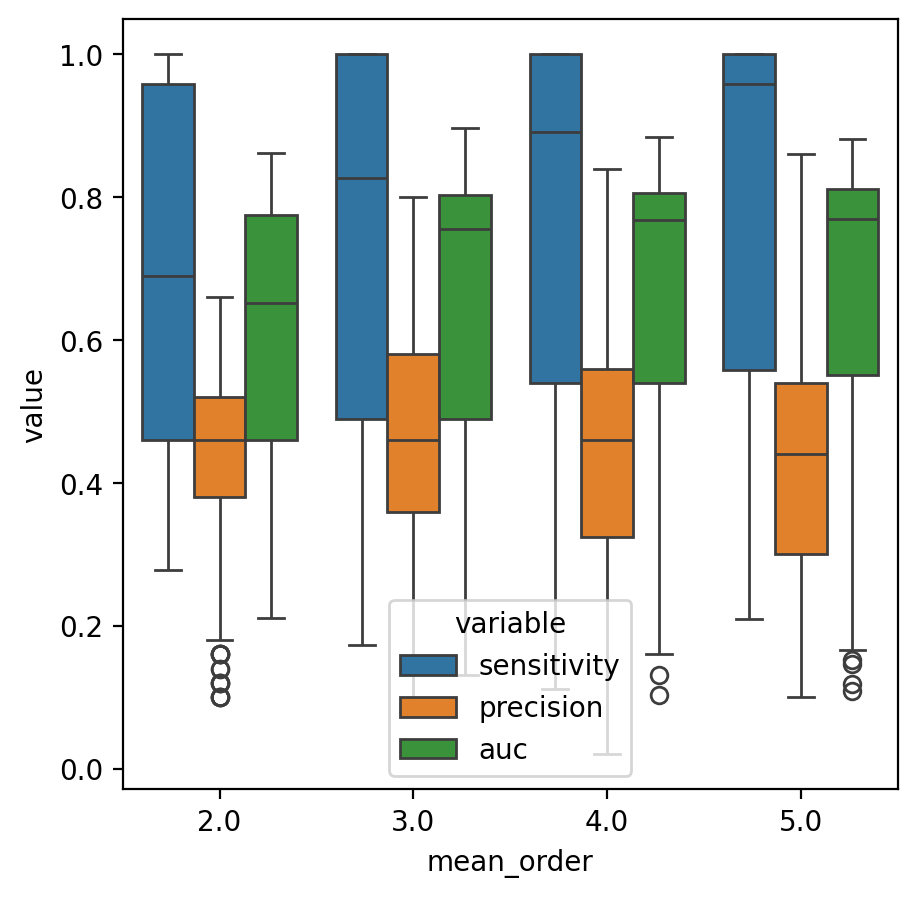

In [35]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

pdf = results.copy()
pdf = pd.melt(
    pdf,
    id_vars='mean_order',
    value_vars=['sensitivity', 'precision', 'auc']
)

sns.boxplot(
    pdf, 
    x='variable',
    y='value',
    hue='variable',
)

pdf.head()


# sns.scatterplot(
#     data=results,
#     x='mean_c_score',
#     y='mean_p_score',
#     hue='mean_order',
#     ec='k',  
#     s=15,
# )


In [ ]:
break

In [ ]:
total_nodes = 100
num_core_nodes = int(0.25 * (total_nodes))
print(num_core_nodes)
num_periphery_nodes = total_nodes - num_core_nodes
avg_edge_size = 3
steps = 50

core_core_range = np.linspace(0, 1, steps)
edge_probability_periphery = 0.25
core_periphery_probability = 0.05

results = []


for edge_probability_core in core_core_range:

    core_nodes, _, _, H = core_utils.generate_core_periphery_hypergraph(
        num_core_nodes, 
        num_periphery_nodes, 
        edge_probability_core, 
        edge_probability_periphery, 
        avg_edge_size, 
        core_periphery_probability,
    )
    
    score, _ = central.nonlinear_eigenvector_centrality(
        H, 
        function='linear', 
        maxiter=1000,
    )
    
    row = {
        'core_px' : edge_probability_core,
    }
    
    for i in range(total_nodes):
        row[i] = score[i]
            
    results.append(row)    
    # break
    
results = pd.DataFrame(results)
print(f"{results.shape=}")
results.head()

In [ ]:
break

In [ ]:
# res = []

# for core_size, group in results.groupby('core_size'):
#     group = group.drop(columns='core_size')
#     core_cols = group.columns[:core_size]
#     print(group)
    
    
#     break

In [ ]:
break

In [ ]:
def generate_params(
    num_nodes=100,
    num_core_nodes=(5, 95, 1),
    core_core_probability=0.95,
    periphery_periphery_probability=0.1,
    core_periphery_probability=0.25,
    avg_edge_size=3
):
    """
    Generates a DataFrame of parameters for a network model.

    Args:
        num_nodes: The total number of nodes in the network.
        num_core_nodes: A tuple specifying the range and step size for the number of core nodes.
        core_core_probability: The probability of an edge between two core nodes.
        periphery_periphery_probability: The probability of an edge between two periphery nodes.
        core_periphery_probability: The probability of an edge between a core node and a periphery node.
        avg_edge_size: The average size of an edge.

    Returns:
        A DataFrame where each row represents a set of parameters for the network model.
    """

    data = {}

    # Handle arguments that can be tuples or ints
    for arg_name, arg_value in locals().items():
        if isinstance(arg_value, tuple):
            data[arg_name] = np.arange(*arg_value)
        else:
            data[arg_name] = [arg_value] * num_nodes  # Repeat int values for each node

    # Create the DataFrame
    df = pd.DataFrame(data)

    return df




params = generate_params()
print(len(params))
params.head()

# Generate the Hypergraphs

In [ ]:
metadata = {}
hypergraph = {}

for _, row in params.iterrows():
    key = row['hypergraph_key']
    
    CPH = make_core.generate_core_periphery_hypergraph(
        int(row['num_core_nodes']),
        int(row['num_periphery_nodes']), 
        row['edge_probability_core'], 
        row['edge_probability_periphery'], 
        row['avg_edge_size'], 
        row['core_periphery_probability'],
    )
    
    core_nodes, periphery_nodes, edges, incidence_matrix = CPH
    metadata[key] = {
        'core_nodes' : core_nodes,
        'periphery_nodes' : periphery_nodes,
    }
    
    hypergraph[key] = pd.DataFrame(incidence_matrix)

print('done')    

# Compute centralities

In [ ]:
cdf = []

for key, H in hypergraph.items():
    ncent, ecent = central.nonlinear_eigenvector_centrality(
        H.to_numpy(), 
        function='linear', 
        maxiter=1000,
    )
    
    nodes = pd.DataFrame({
        'hypergraph_key' : int(key),
        'node' : H.index.to_list(),
        'centrality' : ncent,
    })
    
    core_nodes = metadata[key]['core_nodes']
    nodes['core'] = nodes['node'].isin(core_nodes)
    cdf.append(nodes)
    
cdf = pd.concat(cdf)
print(f"{cdf.shape=}")
cdf.head()

In [ ]:
sns.scatterplot(
    data=pdf,
    x='edge_probability_core',
    y='centrality',
)

In [ ]:
sns.boxplot(
    data=cdf, 
    x='core',
    y='centrality',
    showfliers=False,
)

In [ ]:
break

In [ ]:
sns.boxplot(
    data=cdf, 
    x='centrality',
    y='core',
)

In [ ]:
break

In [ ]:
# 

In [ ]:
aucs = {}
for key, group in cdf.groupby('hypergraph'):
    auc = sklearn.metrics.roc_auc_score(group['core'], group['centrality'])
    aucs[key] = auc
    
params['aucs'] = params['hypergraph_key'].map(aucs)
params.head()

In [ ]:
sns.scatterplot(
    data=params,
    x='num_core_nodes',
    y='aucs',
)

In [ ]:
test = pd.pivot_table(
    cdf, 
    index='node',
    columns='hypgraph',
    values='centrality',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(
    test,
    square=True,
    cbar_kws={'shrink' : 0.5,}
)

In [ ]:
sns.scatterplot(
    data=cdf,
    x='node',
    y='centrality',
    hue='core',
    ec='none',
    alpha=0.5,
)

In [ ]:
break

In [ ]:
break

# Size of the Core

In [ ]:
edge_probability_core = 0.95
edge_probability_periphery = 0.1
avg_edge_size = 3
core_periphery_probability = 0.1

hypergraphs = {}
results = []

for i in np.arange(3, 100):
    
    num_core_nodes = i
    num_periphery_node = 100 - i

    CPH = make_core.generate_core_periphery_hypergraph(
        num_core_nodes, 
        num_periphery_nodes, 
        edge_probability_core, 
        edge_probability_periphery, 
        avg_edge_size, 
        core_periphery_probability,
    )
    
    core_nodes, periphery_nodes, edges, incidence_matrix = CPH
    
    hypergraphs[i] = incidence_matrix
    

# core_nodes, periphery_nodes, edges, incidence_matrix = result

In [ ]:
break

# Compute nonlinear node centrality

In [ ]:
ncent, ecent = central.nonlinear_eigenvector_centrality(H.to_numpy(), 
                                                        function='linear', 
                                                        maxiter=1000)
nodes = pd.DataFrame({
    'node' : H.index.to_list(),
    'centrality' : ncent,
})

nodes['core'] = nodes['node'].isin(core_nodes)

nodes = nodes.sort_values(by='centrality', 
                          ascending=False,)
nodes.head()